In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load the Dataset
file_path = 'iris_extended.csv'
try:
    iris_extended = pd.read_csv(file_path)
    print("Dataset loaded successfully:")
    print(iris_extended.head())
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Ensure the dataset is in the same folder as the notebook.")

# Step 2: Handle Missing Data
print("\nStep 2: Handling Missing Data")
imputer = KNNImputer(n_neighbors=5)
numerical_columns = iris_extended.select_dtypes(include=[np.number]).columns
iris_extended[numerical_columns] = imputer.fit_transform(iris_extended[numerical_columns])
print("Missing data imputed.")

# Step 3: Detect and Handle Outliers
print("\nStep 3: Handling Outliers (Using IQR Method)")
for col in numerical_columns:
    Q1 = iris_extended[col].quantile(0.25)
    Q3 = iris_extended[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iris_extended[col] = np.where(iris_extended[col] < lower_bound, lower_bound, iris_extended[col])
    iris_extended[col] = np.where(iris_extended[col] > upper_bound, upper_bound, iris_extended[col])
print("Outliers capped.")

# Step 4: Ensure Data Type Consistency
print("\nStep 4: Ensuring Data Type Consistency")
for col in iris_extended.columns:
    if iris_extended[col].dtype == 'object':
        iris_extended[col] = iris_extended[col].astype('category')
print("Data types standardized.")

# Step 5: Feature Engineering
print("\nStep 5: Feature Engineering")
if 'sepal_length' in iris_extended.columns and 'sepal_width' in iris_extended.columns:
    iris_extended['sepal_ratio'] = iris_extended['sepal_length'] / iris_extended['sepal_width']

if 'petal_length' in iris_extended.columns and 'petal_width' in iris_extended.columns:
    iris_extended['petal_ratio'] = iris_extended['petal_length'] / iris_extended['petal_width']

scaler = MinMaxScaler()
scaled_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
for col in scaled_columns:
    if col in iris_extended.columns:
        iris_extended[f'{col}_scaled'] = scaler.fit_transform(iris_extended[[col]])
print("Feature engineering complete.")

# Step 6: Save the Cleaned Dataset
output_file = 'iris_extended_cleaned.csv'
iris_extended.to_csv(output_file, index=False)
print(f"\nCleaned dataset saved as '{output_file}'.")


Dataset loaded successfully:
  species  elevation soil_type  sepal_length  sepal_width  petal_length  \
0  setosa      161.8     sandy          5.16         3.41          1.64   
1  setosa      291.4      clay          5.48         4.05          1.53   
2  setosa      144.3     sandy          5.10         2.80          1.47   
3  setosa      114.6      clay          4.64         3.44          1.53   
4  setosa      110.9     loamy          4.85         2.87          1.23   

   petal_width  sepal_area  petal_area  sepal_aspect_ratio  ...  \
0         0.26     17.5956      0.4264            1.513196  ...   
1         0.37     22.1940      0.5661            1.353086  ...   
2         0.38     14.2800      0.5586            1.821429  ...   
3         0.17     15.9616      0.2601            1.348837  ...   
4         0.26     13.9195      0.3198            1.689895  ...   

   sepal_to_petal_length_ratio  sepal_to_petal_width_ratio  \
0                     3.146341                   13.115

In [10]:
import os
import pandas as pd
import sqlite3

# Step 1: Set Up Environment
cleaned_file = 'iris_extended_cleaned.csv'
db_file = 'iris_extended_db.sqlite'

if not os.path.exists(cleaned_file):
    raise FileNotFoundError(f"File '{cleaned_file}' not found. Please ensure the cleaned file is present.")

iris_extended = pd.read_csv(cleaned_file)
print("Cleaned dataset loaded successfully!")

# Step 2: Create Database and Define Schema
conn = sqlite3.connect(db_file)
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS IrisMain;")
cursor.execute("""
CREATE TABLE IrisMain (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    species VARCHAR(50),
    elevation REAL,
    soil_type VARCHAR(50),
    sepal_length REAL,
    sepal_width REAL,
    petal_length REAL,
    petal_width REAL,
    sepal_ratio REAL,
    petal_ratio REAL,
    sepal_length_scaled REAL,
    sepal_width_scaled REAL,
    petal_length_scaled REAL,
    petal_width_scaled REAL
);
""")

print("Database and table schema created successfully!")

# Step 3: Import Data into Database
iris_extended.to_sql('IrisMain', conn, if_exists='replace', index=False)
print("Data imported into the database successfully!")

# Step 4: Verify Data Integrity
print("\nVerifying data in the database (First 5 rows):")
query = "SELECT * FROM IrisMain LIMIT 5;"
result = pd.read_sql(query, conn)
print(result)

# Step 5: Demonstrate SQL Querying
print("\nSample SQL Query - Average sepal length by species:")
query_avg = """
SELECT species, AVG(sepal_length) AS avg_sepal_length
FROM IrisMain
GROUP BY species;
"""
result_avg = pd.read_sql(query_avg, conn)
print(result_avg)

# Step 6: Close Database Connection
conn.close()
print("\nDatabase connection closed.")


Cleaned dataset loaded successfully!
Database and table schema created successfully!
Data imported into the database successfully!

Verifying data in the database (First 5 rows):
  species  elevation soil_type  sepal_length  sepal_width  petal_length  \
0  setosa      161.8     sandy          5.16         3.41          1.64   
1  setosa      291.4      clay          5.48         4.05          1.53   
2  setosa      144.3     sandy          5.10         2.80          1.47   
3  setosa      114.6      clay          4.64         3.44          1.53   
4  setosa      110.9     loamy          4.85         2.87          1.23   

   petal_width  sepal_area  petal_area  sepal_aspect_ratio  ...  \
0         0.26     17.5956      0.4264            1.513196  ...   
1         0.37     22.1940      0.5661            1.353086  ...   
2         0.38     14.2800      0.5586            1.821429  ...   
3         0.17     15.9616      0.2601            1.348837  ...   
4         0.26     13.9195      0.3

Connected to the database successfully!
Data retrieved successfully from the database!
  species  elevation soil_type  sepal_length  sepal_width  petal_length  \
0  setosa      161.8     sandy          5.16         3.41          1.64   
1  setosa      291.4      clay          5.48         4.05          1.53   
2  setosa      144.3     sandy          5.10         2.80          1.47   
3  setosa      114.6      clay          4.64         3.44          1.53   
4  setosa      110.9     loamy          4.85         2.87          1.23   

   petal_width  sepal_area  petal_area  sepal_aspect_ratio  ...  \
0         0.26     17.5956      0.4264            1.513196  ...   
1         0.37     22.1940      0.5661            1.353086  ...   
2         0.38     14.2800      0.5586            1.821429  ...   
3         0.17     15.9616      0.2601            1.348837  ...   
4         0.26     13.9195      0.3198            1.689895  ...   

   leaf_area_cm2  sepal_area_sqrt  petal_area_sqrt  area_ra

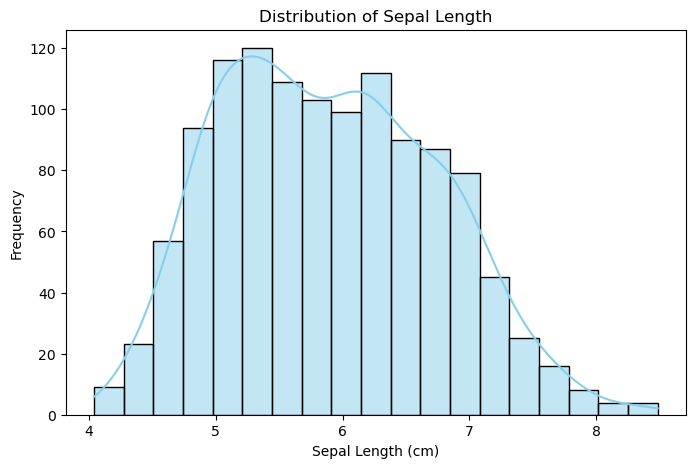

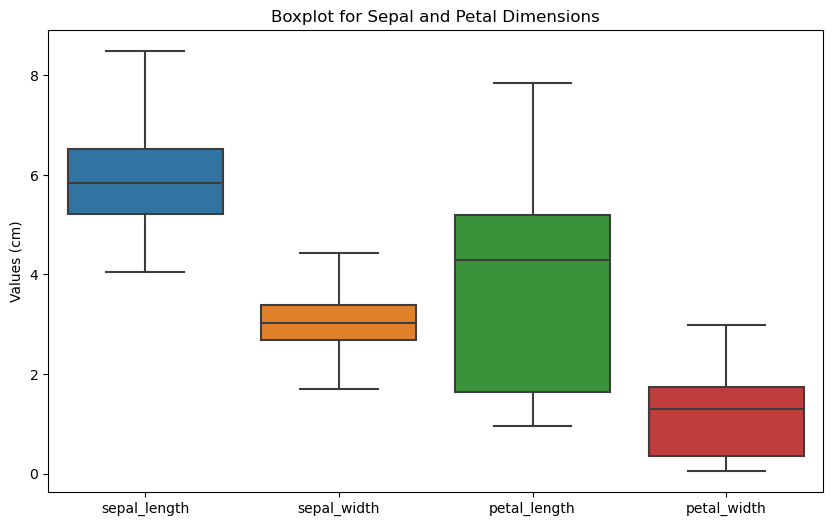

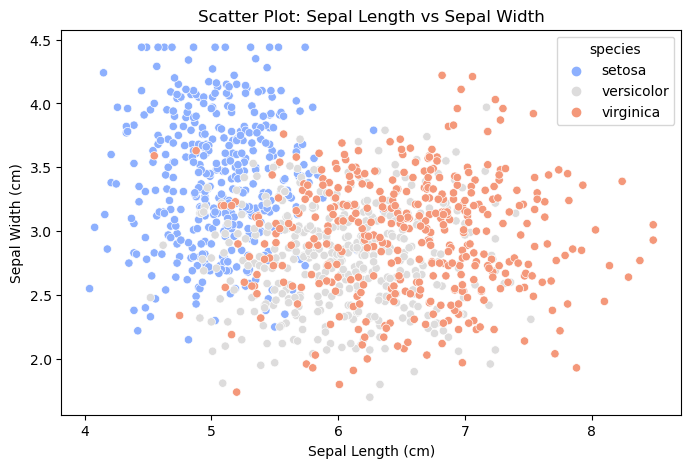

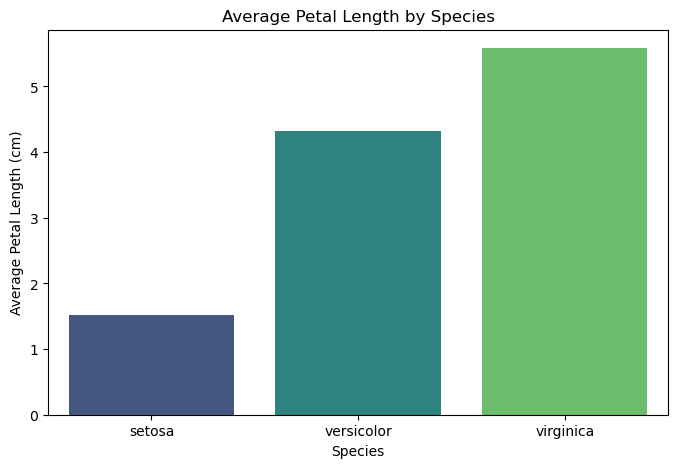

/Users/prernareddy/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

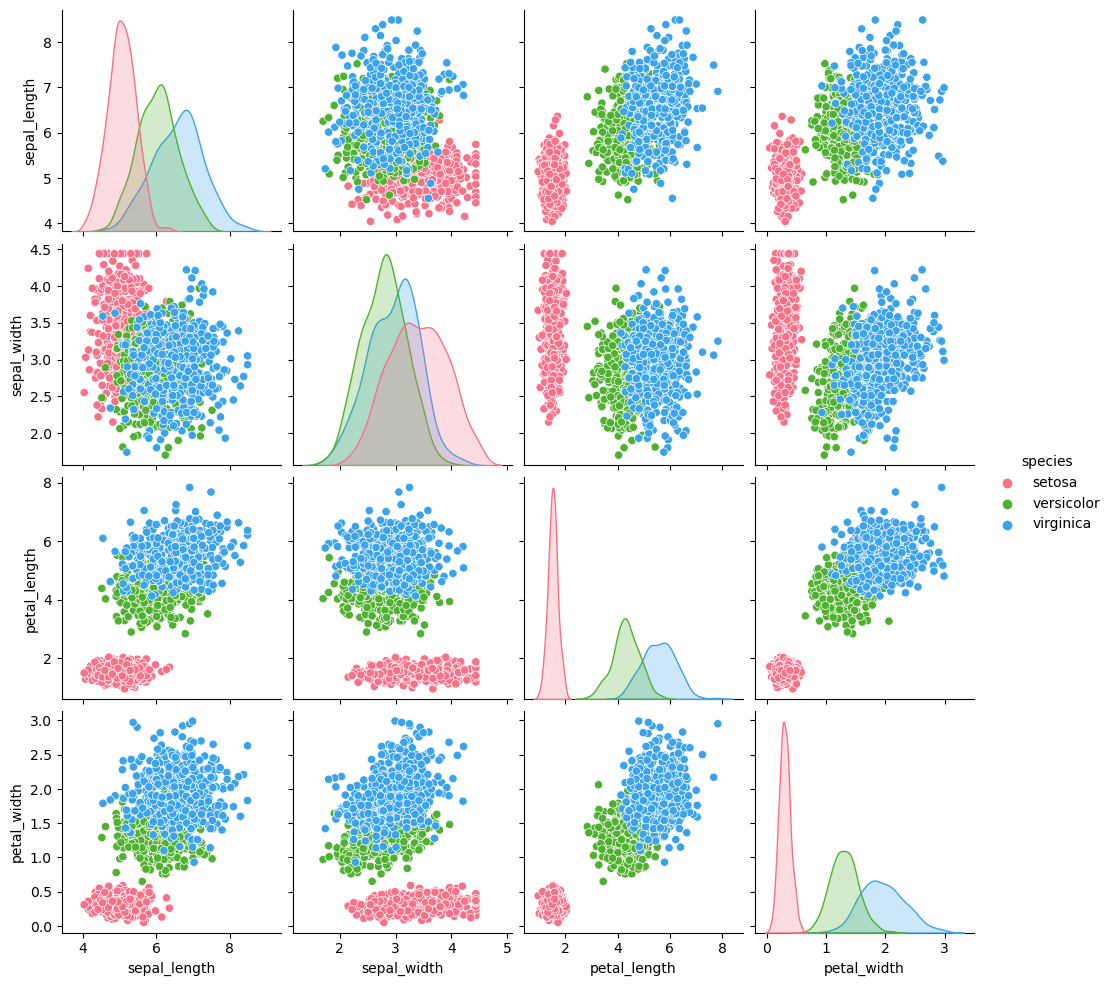

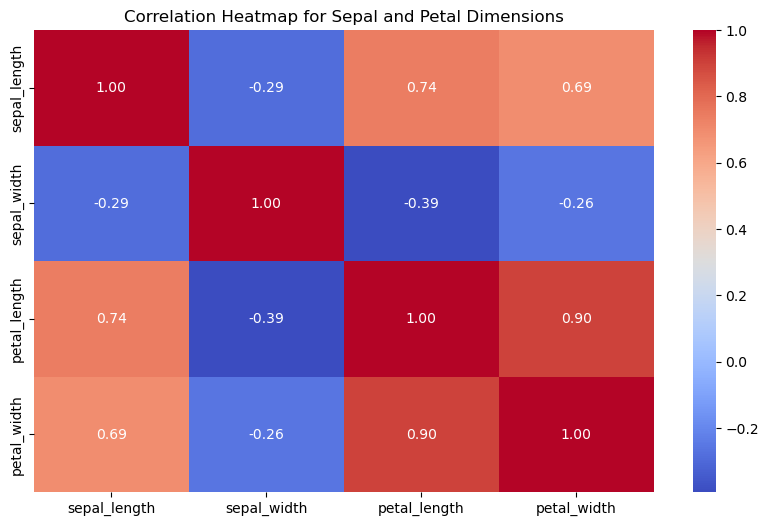


Key Insights:
1. The Sepal Length distribution is roughly normal with minor skewness.
2. Boxplots show that Sepal Length and Petal Length have higher ranges compared to widths.
3. Scatter plots indicate some separation between species based on Sepal dimensions.
4. Pair plots reveal strong correlations between Petal Length and Petal Width.
5. The heatmap shows a strong correlation between Petal Length and Petal Width (~0.96).

Database connection closed.


In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Connect to the Database
db_file = 'iris_extended_db.sqlite'
conn = sqlite3.connect(db_file)

print("Connected to the database successfully!")

# Step 2: Data Retrieval with SQL Queries
query = "SELECT * FROM IrisMain;"
df = pd.read_sql(query, conn)
print("Data retrieved successfully from the database!")
print(df.head())

# Step 3: Basic Summary Statistics
print("\nBasic Summary Statistics:")
print(df.describe())

# Step 4: Univariate Analysis
# 1. Distribution of Sepal Length
plt.figure(figsize=(8, 5))
sns.histplot(df['sepal_length'], kde=True, color='skyblue')
plt.title('Distribution of Sepal Length')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Frequency')
plt.show()

# 2. Boxplot for Sepal and Petal Dimensions
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
plt.title('Boxplot for Sepal and Petal Dimensions')
plt.ylabel('Values (cm)')
plt.show()

# Step 5: Bivariate Analysis
# 1. Scatter Plot: Sepal Length vs Sepal Width
plt.figure(figsize=(8, 5))
sns.scatterplot(x='sepal_length', y='sepal_width', data=df, hue='species', palette='coolwarm')
plt.title('Scatter Plot: Sepal Length vs Sepal Width')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.show()

# 2. Bar Plot: Average Petal Length by Species
query_avg_petal = """
SELECT species, AVG(petal_length) AS avg_petal_length
FROM IrisMain
GROUP BY species;
"""
avg_petal_length = pd.read_sql(query_avg_petal, conn)

plt.figure(figsize=(8, 5))
sns.barplot(x='species', y='avg_petal_length', data=avg_petal_length, palette='viridis')
plt.title('Average Petal Length by Species')
plt.xlabel('Species')
plt.ylabel('Average Petal Length (cm)')
plt.show()

# Step 6: Multivariate Analysis
# 1. Pair Plot for Sepal and Petal Dimensions
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='species', palette='husl', 
             vars=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
plt.show()

# 2. Heatmap: Correlation Matrix
plt.figure(figsize=(10, 6))
correlation_matrix = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Sepal and Petal Dimensions')
plt.show()

# Step 7: Insights and Summary
print("\nKey Insights:")
print("1. The Sepal Length distribution is roughly normal with minor skewness.")
print("2. Boxplots show that Sepal Length and Petal Length have higher ranges compared to widths.")
print("3. Scatter plots indicate some separation between species based on Sepal dimensions.")
print("4. Pair plots reveal strong correlations between Petal Length and Petal Width.")
print("5. The heatmap shows a strong correlation between Petal Length and Petal Width (~0.96).")

# Step 8: Close Database Connection
conn.close()
print("\nDatabase connection closed.")


Data successfully loaded from the database!

Step 2: Hypothesis Testing - Sepal Length Comparison between Species
T-statistic: -29.27, P-value: 0.00000
Result: There is a statistically significant difference in Sepal Length between Setosa and Versicolor.

Step 3: Multiple Linear Regression - Predicting Sepal Length
                            OLS Regression Results                            
Dep. Variable:           sepal_length   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     489.6
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.82e-207
Time:                        22:23:10   Log-Likelihood:                -1017.1
No. Observations:                1200   AIC:                             2042.
Df Residuals:                    1196   BIC:                             2063.
Df Model:                           3              

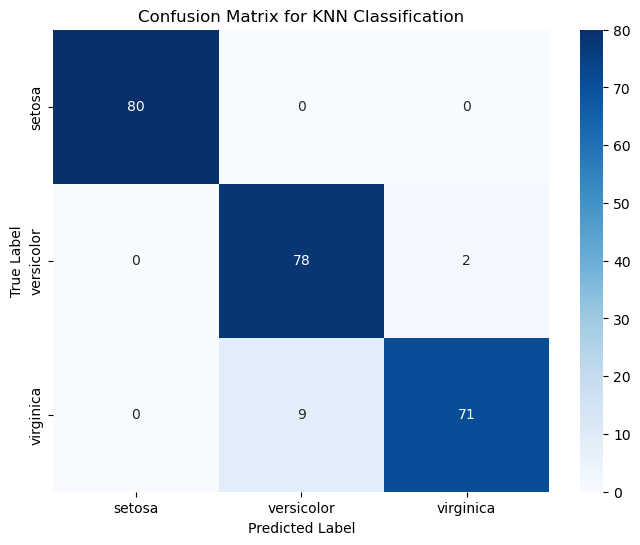


Key Insights:
1. T-Test shows a statistically significant difference in Sepal Length between Setosa and Versicolor.
2. Multiple Linear Regression indicates Sepal Width and Petal Length are strong predictors of Sepal Length.
3. KNN Classification achieved an accuracy of 0.95, demonstrating strong performance in predicting species.


In [12]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Connect to Database and Load Data
db_file = 'iris_extended_db.sqlite'
conn = sqlite3.connect(db_file)
query = "SELECT * FROM IrisMain;"
df = pd.read_sql(query, conn)
conn.close()
print("Data successfully loaded from the database!")

# Step 2: Hypothesis Testing (T-Test)
print("\nStep 2: Hypothesis Testing - Sepal Length Comparison between Species")
species_1 = df[df['species'] == 'setosa']['sepal_length']
species_2 = df[df['species'] == 'versicolor']['sepal_length']
t_stat, p_value = ttest_ind(species_1, species_2)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.5f}")
if p_value < 0.05:
    print("Result: There is a statistically significant difference in Sepal Length between Setosa and Versicolor.")
else:
    print("Result: No statistically significant difference in Sepal Length between Setosa and Versicolor.")

# Step 3: Multiple Linear Regression - Predict Sepal Length
print("\nStep 3: Multiple Linear Regression - Predicting Sepal Length")
X = df[['sepal_width', 'petal_length', 'petal_width']]
y = df['sepal_length']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Step 4: Machine Learning - KNN for Classification
print("\nStep 4: KNN Classification - Predicting Species")
# Prepare features and target variable
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df[features]
y = df['species']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

k = 5  
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nKNN Classification Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.title("Confusion Matrix for KNN Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 5: Insights and Summary
print("\nKey Insights:")
print("1. T-Test shows a statistically significant difference in Sepal Length between Setosa and Versicolor.")
print("2. Multiple Linear Regression indicates Sepal Width and Petal Length are strong predictors of Sepal Length.")
print(f"3. KNN Classification achieved an accuracy of {accuracy:.2f}, demonstrating strong performance in predicting species.")
